In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision.datasets import MNIST
from torchvision.models import resnet18
from torchvision.transforms import *
from torchvision.utils import make_grid
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import numpy as np
import itertools
from vos import VOS

# Load data, set up problem

In [2]:
dataset = MNIST(root = "~/datasets/MNIST", train = True)
transform = Compose([lambda x: x.float(), Normalize((0.1307,), (0.3081,))])

samples = dataset.data
targets = dataset.targets
data = TensorDataset(transform(samples).unsqueeze(1), targets)

loader = DataLoader(data, batch_size = 64)

In [3]:
data_dict = {key:[] for key in dataset.targets.unique().tolist()}
for batch in loader:
    x, y = batch
    for pair in zip(x, y):
        x, y = pair
        data_dict[y.item()].append(x)

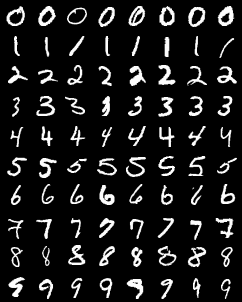

In [4]:
images = [random.sample(data_dict[key], 8) for key in np.sort(list(data_dict.keys()))]
images = torch.stack(list(itertools.chain.from_iterable(images)))
grid = make_grid(images, nrow = 8, normalize = True)

img = ToPILImage()(grid)
img

In [5]:
backbone = resnet18()
backbone.conv1 = nn.Conv2d(1, 64, kernel_size = (7, 7), stride = (2, 2), padding = (3, 3), bias = False)
backbone.fc = nn.Linear(512, 10)

In [6]:
class OODDetector(nn.Module):
    def __init__(self, latent_dim = 512):
        super().__init__()
        self.latent_dim = latent_dim
        self.mlp = nn.Sequential(nn.Linear(1, latent_dim),
                                 nn.ReLU(),
                                 nn.Linear(latent_dim, 1))
    
    def forward(self, x):
        out = self.mlp(x)
        return out
    
ood_detector = OODDetector(latent_dim = 512)

# Optional model pretraining

In [7]:
pretrain = False
if pretrain:
    criterion = nn.CrossEntropyLoss()
    opt = Adam(backbone.parameters(), lr = 1e-3)
    print(f"CUDA is {torch.cuda.is_available()}")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    backbone.to(device)

    epochs = 25
    for epoch in range(epochs):
        running_loss = 0.
        iteration_counter = 0
        for batch in loader:
            samples, targets = batch
            samples, targets = samples.to(device), targets.to(device)

            opt.zero_grad()

            outputs = backbone(samples)

            loss = criterion(outputs, F.one_hot(targets).float())
            loss.backward()

            opt.step()

            running_loss += loss
            iteration_counter += 1
        
        if epoch % 5 == 4:
            print(f"Epoch: {epoch + 1}")
            print(f"Loss: {running_loss/iteration_counter}")

    backbone.to("cpu")
    backbone.eval()
    torch.save(backbone, "pretrained_model.pt")
else:
    backbone = torch.load("pretrained_model.pt", weights_only = False)

# Set up VOS

In [8]:
vos = VOS(backbone, ood_detector, data, queue_size = 1024)

show_covs = False
if show_covs:
    fig = plt.figure(figsize = (15, 6))

    # Show the initialized covariance
    plt.subplot(1, 2, 1)
    initial_cov = plt.imshow(vos.cov, cmap = "hot", interpolation = "nearest")
    plt.axis("off")
    plt.title("Initialization Covariance")
    plt.colorbar()

    # Update the GMM with the samples currently in the queue
    vos.update_gmm()

    # Show the covariance structure after the GMM has been updated
    plt.subplot(1, 2, 2)
    initial_cov = plt.imshow(vos.cov, cmap = "hot", interpolation = "nearest")
    plt.axis("off")
    plt.title("Evaluated Covariance")
    plt.clim(0, 1)
    plt.colorbar()
    plt.show()

# Data visualizations

In [9]:
target = 6
n_samples = 10
sample = torch.stack(random.sample(vos.queue[target], n_samples))
latents = vos.stripped_backbone(sample).squeeze().detach()
vos.compute_gmm_log_likelihood(latents, target)

tensor([-669.0930, -739.6124, -934.6648, -872.8262, -868.6359, -970.2495,
        -826.2523, -841.4083, -649.4407, -575.2593])

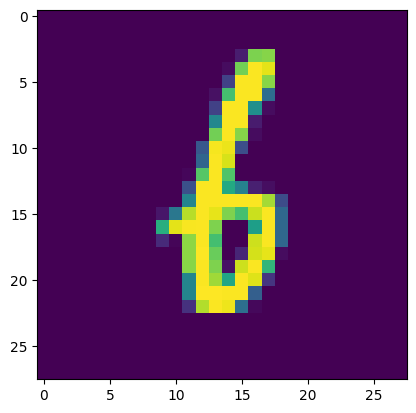

In [10]:
plt.imshow(sample[0].squeeze())

In [11]:
torch.argmax(vos.backbone(sample), dim = 1)

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6])

In [12]:
mode = vos.class_conditional_modes[target]

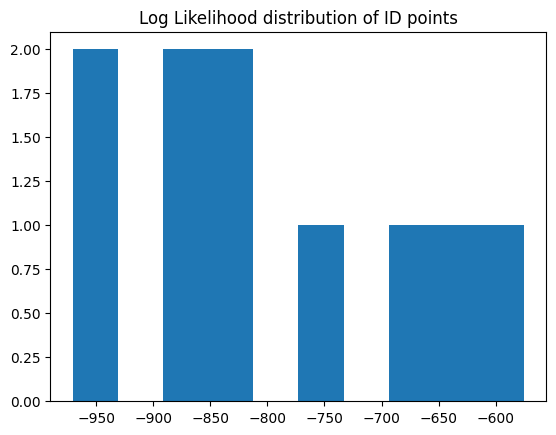

In [13]:
id_likelihoods = vos.compute_gmm_log_likelihood(latents, target)
plt.hist(id_likelihoods)
plt.title("Log Likelihood distribution of ID points")
plt.show()

In [14]:
log_epsilon = vos.select_log_epsilon(t=1)

In [15]:
log_epsilon

tensor(-4612.1113)

In [16]:
vos.sample_ood()

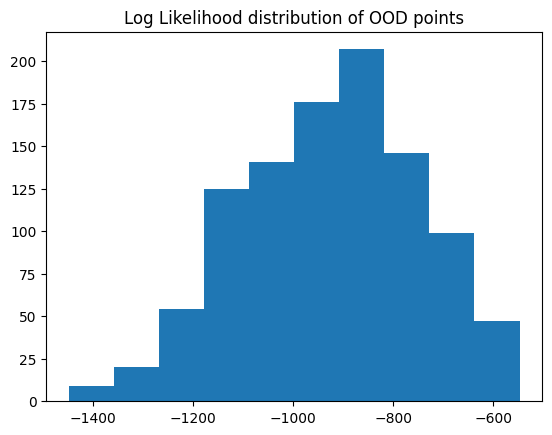

In [17]:
ood_likelihoods = vos.compute_gmm_log_likelihood(vos.ood_queue[target], target)
plt.hist(ood_likelihoods)
plt.title("Log Likelihood distribution of OOD points")
plt.show()

# Train VOS

In [18]:
vos.train(iterations = 10, lr = 1e-3, beta = 0.1)

Iteration: 0
Classification Loss: 0.004277441184967756
Uncertainty Loss: 25.24889373779297
Iteration: 1
Classification Loss: 0.004357443191111088
Uncertainty Loss: 11.403306007385254
Iteration: 2
Classification Loss: 0.004298666957765818
Uncertainty Loss: 22.554651260375977
Iteration: 3
Classification Loss: 0.0041536190547049046
Uncertainty Loss: 15.778697967529297
Iteration: 4
Classification Loss: 0.003952852450311184
Uncertainty Loss: 10.850175857543945
Iteration: 5
Classification Loss: 0.0037497051525861025
Uncertainty Loss: 11.1593656539917
Iteration: 6
Classification Loss: 0.0035926736891269684
Uncertainty Loss: 12.124588966369629
Iteration: 7
Classification Loss: 0.0034646340645849705
Uncertainty Loss: 12.487565994262695
Iteration: 8
Classification Loss: 0.0033598369918763638
Uncertainty Loss: 12.305310249328613
Iteration: 9
Classification Loss: 0.00328647717833519
Uncertainty Loss: 11.819186210632324


# Save model

In [19]:
torch.save(vos.backbone, "vos_model.pt")

In [20]:
torch.save(vos.ood_detector, "vos_ood_detector.pt")

In [21]:
vos.uncertainty_loss()

tensor(30.0732, grad_fn=<AddBackward0>)

# Demonstrate some post-training metrics on synthesized data

In [22]:
id_loss, ood_loss = 0., 0.
key = 9
id_points = torch.stack(vos.queue[key])
id_logits = vos.backbone(id_points)

ood_latents = vos.ood_queue[key]
classifier = list(vos.backbone.children())[-1]
ood_logits = classifier(ood_latents)

id_energies, ood_energies = vos.free_energy(id_logits), vos.free_energy(ood_logits)
id_energy_surface, ood_energy_surface = vos.ood_detector(id_energies), vos.ood_detector(ood_energies)

id_loss += torch.mean(-torch.log(torch.exp(-id_energy_surface)/(1 + torch.exp(-id_energy_surface))))
ood_loss += torch.mean(-torch.log(1/(1 + torch.exp(-ood_energy_surface))))

In [23]:
id_loss

tensor(2.1312, grad_fn=<AddBackward0>)

In [24]:
ood_loss

tensor(0.0351, grad_fn=<AddBackward0>)

In [25]:
F.softmax(id_logits[0])

/tmp/ipykernel_54071/3561630357.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(id_logits[0])


tensor([0.0000e+00, 9.6183e-15, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
       grad_fn=<SoftmaxBackward0>)

# At the end of training, we want one group to be positive, one group to be negative

In [28]:
id_energies

tensor([[23.2711],
        [13.6176],
        [22.6162],
        [20.6813],
        [ 2.4290],
        [ 8.4464],
        [32.9894],
        [10.6584],
        [17.4954],
        [-8.6168]], grad_fn=<NegBackward0>)

In [29]:
ood_energies

tensor([[-23.9822],
        [-22.4153],
        [-27.2566],
        [-26.1628],
        [-35.0841],
        [-29.3959],
        [-29.0700],
        [-36.3796],
        [-32.9910],
        [-29.1847]], grad_fn=<NegBackward0>)